<a href="https://colab.research.google.com/github/KyleRoss-rice/tiny-cifar10-experiments/blob/main/scripts/augmented_dataset_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global setup

In [ ]:
dataset_dir = "datasets/CIFAR-10/Train" #@param {type:"string"}
n_subsets = 3 #@param {type:"slider", min:1, max:5, step:1}
n_samples_per_class = 10 #@param {type:"slider", min:1, max:20, step:1}
n_augmentations = 15 #@param {type:"slider", min:0, max:20, step:1}
is_download_subsets = True #@param {type:"boolean"}


In [ ]:
# import libraries
## pytorch
import torch
from torchvision import datasets, transforms

## data augmentation
!pip install imgaug -U -q
import imgaug
from imgaug import augmenters as iaa

## files
import os
import tarfile
from google.colab import files

## plotting
import matplotlib.pyplot as plt

## basics
import numpy as np

# constants
n_classes = 10

### Data augmentation processor



In [ ]:
# augmentation
augmenter = iaa.SomeOf((1, None), [
                                   iaa.AverageBlur(k=(1,3)),
                                   iaa.Fliplr(1),
                                   iaa.Affine(rotate=(-20, 20), mode='symmetric'),
                                   iaa.ChangeColorTemperature((4000, 10000)),
                                   iaa.MultiplyAndAddToBrightness((1,1.3), (-30, 30)),
                                   iaa.Cutout(fill_mode="gaussian", fill_per_channel=True),
                                   ])


### Download dataset

In [ ]:
# download dataset (if needed)
is_available = False
if os.path.isdir(dataset_dir):
  is_available = True
  print('Will not download dataset — Directory already exists')

cifar10_dataset = datasets.CIFAR10(root=dataset_dir, train=True, download=not is_available)

Will not download dataset — Directory already exists


### Obtain indices for training subsets


In [ ]:
training_indices = [None] * n_subsets

for i in range(n_subsets):
  random_permute = np.random.RandomState(i).permutation(np.arange(0, 5000))

  indices = np.concatenate(
      [np.where(np.array(cifar10_dataset.targets) == label)[0][random_permute[0:n_samples_per_class]] 
       for label in range(0, n_samples_per_class)])

  training_indices[i] = indices

### Obtain indices for validation subset

In [ ]:
validation_indices = np.concatenate(
    [np.where(np.array(cifar10_dataset.targets) == label)[0][random_permute[n_samples_per_class:200+n_samples_per_class]]
     for label in range(0, n_classes)])  

In [ ]:
# validate that no index in the training indices is in the validation indices
for i in range(n_subsets):
  assert(not np.isin(training_indices[i], validation_indices).any())

### Create training subsets

In [ ]:
n_training_samples = n_samples_per_class * n_classes
training_data = np.empty((n_subsets, n_training_samples, 32, 32, 3), dtype=np.uint8)
training_labels = np.empty(n_training_samples, dtype=np.uint8)

for i in range(n_subsets):
  training_data[i] = np.array([cifar10_dataset.data[j] for j in training_indices[i]], dtype=np.uint32)


n_identical_labels = n_samples_per_class
for i in range(n_classes):
  for j in range(n_identical_labels):
    training_labels[i * n_identical_labels + j] = i

### Create augmented training subsets

In [ ]:
n_samples_per_subset = (n_augmentations + 1) * n_samples_per_class * n_classes
aug_training_data = np.empty((n_subsets, n_samples_per_subset, 32, 32, 3), dtype=np.uint8)
aug_training_labels = np.empty((n_samples_per_subset), dtype=np.uint8)

for i in range(n_subsets):
  for j, image_idx in enumerate(training_indices[i]):
    original_image = cifar10_dataset.data[image_idx]
    aug_training_data[i,j * (n_augmentations + 1)] = torch.tensor(original_image)
    for k in range(n_augmentations):
      new_image = augmenter(image=original_image)
      aug_training_data[i,j * (n_augmentations + 1) + k + 1] = torch.tensor(new_image.copy())

n_identical_labels = (n_augmentations + 1) * n_samples_per_class
for i in range(n_classes):
  for j in range(n_identical_labels):
    aug_training_labels[i * n_identical_labels + j] = i

### Create validation set

In [ ]:
validation_data = np.array([cifar10_dataset.data[i] for i in validation_indices], dtype=np.uint8)
validation_labels = np.empty(len(validation_data), dtype=np.uint8)

n_identical_labels = len(validation_data) // n_classes
for i in range(n_classes):
  for j in range(n_identical_labels):
    validation_labels[i * n_identical_labels + j] = i

### Download dataset

In [ ]:
# TODO: code should be simplified here
if is_download_subsets: 
  training_data_export_filename = "tiny-cifar10-training-data.npy"
  training_labels_export_filename = "tiny-cifar10-training-labels.npy"

  aug_training_data_export_filename = "tiny-cifar10-aug-training-data.npy"
  aug_training_labels_export_filename = "tiny-cifar10-aug-training-labels.npy"

  validation_data_export_filename = "tiny-cifar10-validation-data.npy"
  validation_labels_export_filename = "tiny-cifar10-validation-labels.npy"

  np.save(training_data_export_filename, training_data)
  np.save(training_labels_export_filename, training_labels)

  np.save(aug_training_data_export_filename, aug_training_data)
  np.save(aug_training_labels_export_filename, aug_training_labels)

  np.save(validation_data_export_filename, validation_data)
  np.save(validation_labels_export_filename, validation_labels)

  with tarfile.open('tiny-cifar10.tar.gz', 'w:gz') as tar:
    tar.add(training_data_export_filename)
    tar.add(training_labels_export_filename)
    tar.add(aug_training_data_export_filename)
    tar.add(aug_training_labels_export_filename)
    tar.add(validation_data_export_filename)
    tar.add(validation_labels_export_filename)
    tar.list()

    # uncomment this line if you wish to directly download the file
    #files.download('tiny-cifar10.tar.gz')

-rw-r--r-- root/root     921728 2021-04-28 21:01:40 tiny-cifar10-training-data.npy 
-rw-r--r-- root/root        228 2021-04-28 21:01:40 tiny-cifar10-training-labels.npy 
-rw-r--r-- root/root   14745728 2021-04-28 21:01:40 tiny-cifar10-aug-training-data.npy 
-rw-r--r-- root/root       1728 2021-04-28 21:01:40 tiny-cifar10-aug-training-labels.npy 
-rw-r--r-- root/root    6144128 2021-04-28 21:01:40 tiny-cifar10-validation-data.npy 
-rw-r--r-- root/root       2128 2021-04-28 21:01:40 tiny-cifar10-validation-labels.npy 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!cp tiny-cifar10.tar.gz /content/drive/MyDrive/tiny-cifar10/datasets/tiny-cifar10.tar.gz

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Visualize dataset

### Entire first training subset

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


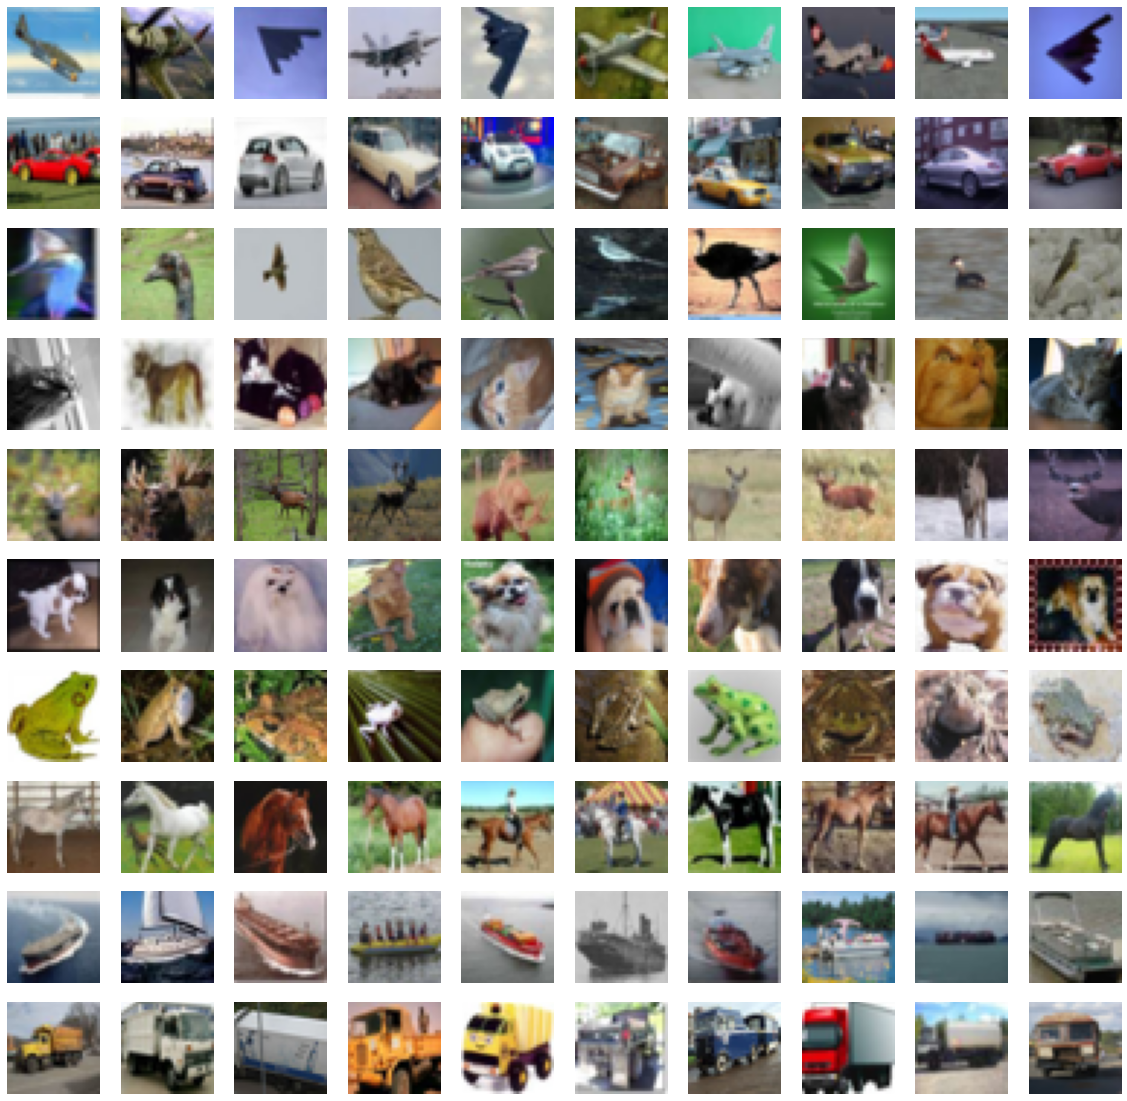

In [ ]:
plt.figure(figsize=(20,20))
for i in range(n_training_samples):
  plt.subplot(n_classes, n_samples_per_class,i+1)
  plt.axis('off')
  plt.imshow(training_data[0][i])

print(training_labels)

### First 100 of first augmented training subset

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


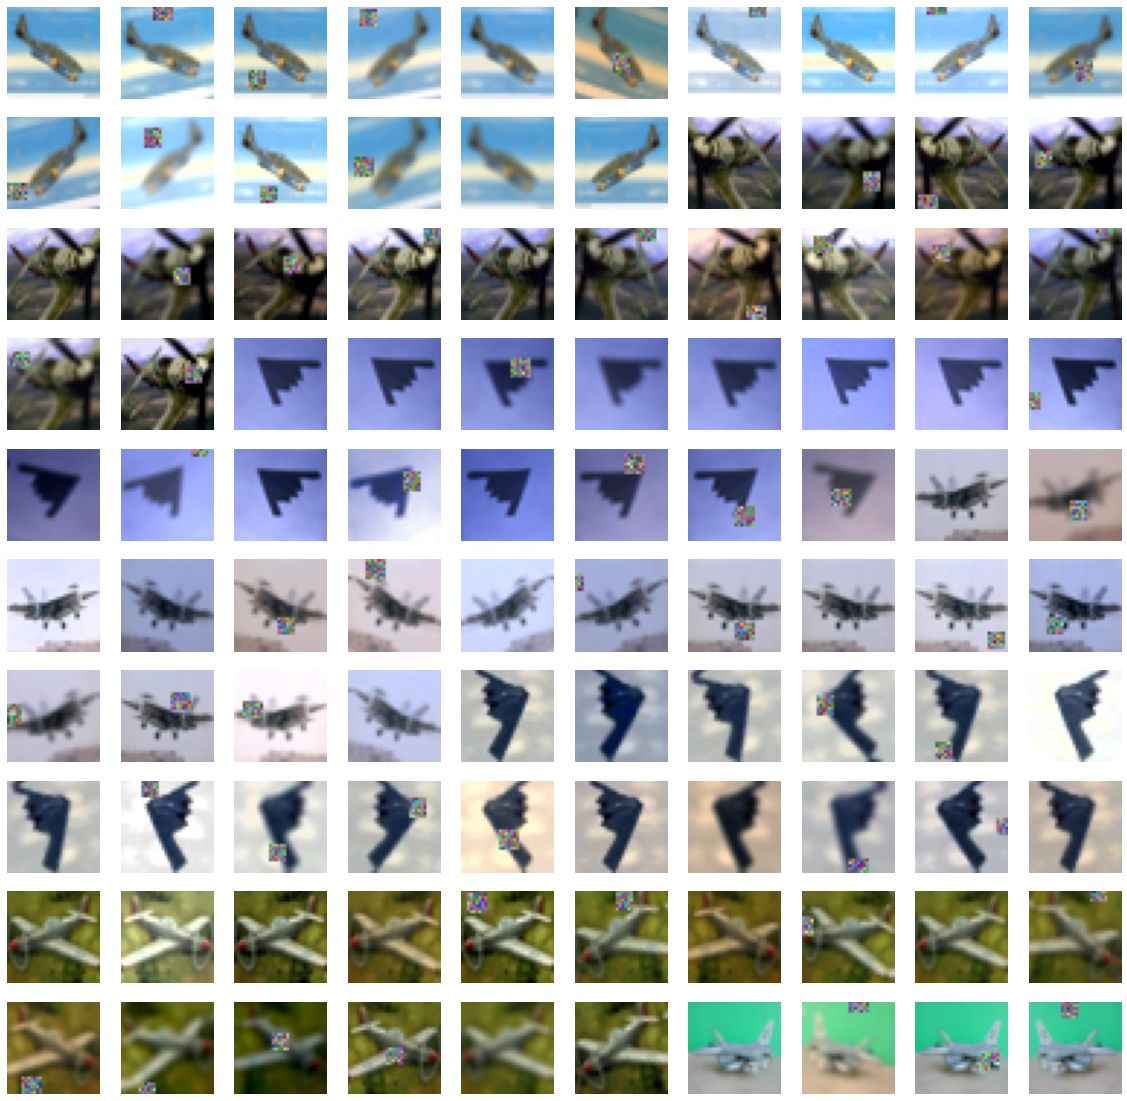

In [ ]:
plt.figure(figsize=(20,20))
for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(aug_training_data[0][i])

print(aug_training_labels[0:100])

### First 100 of validation set

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


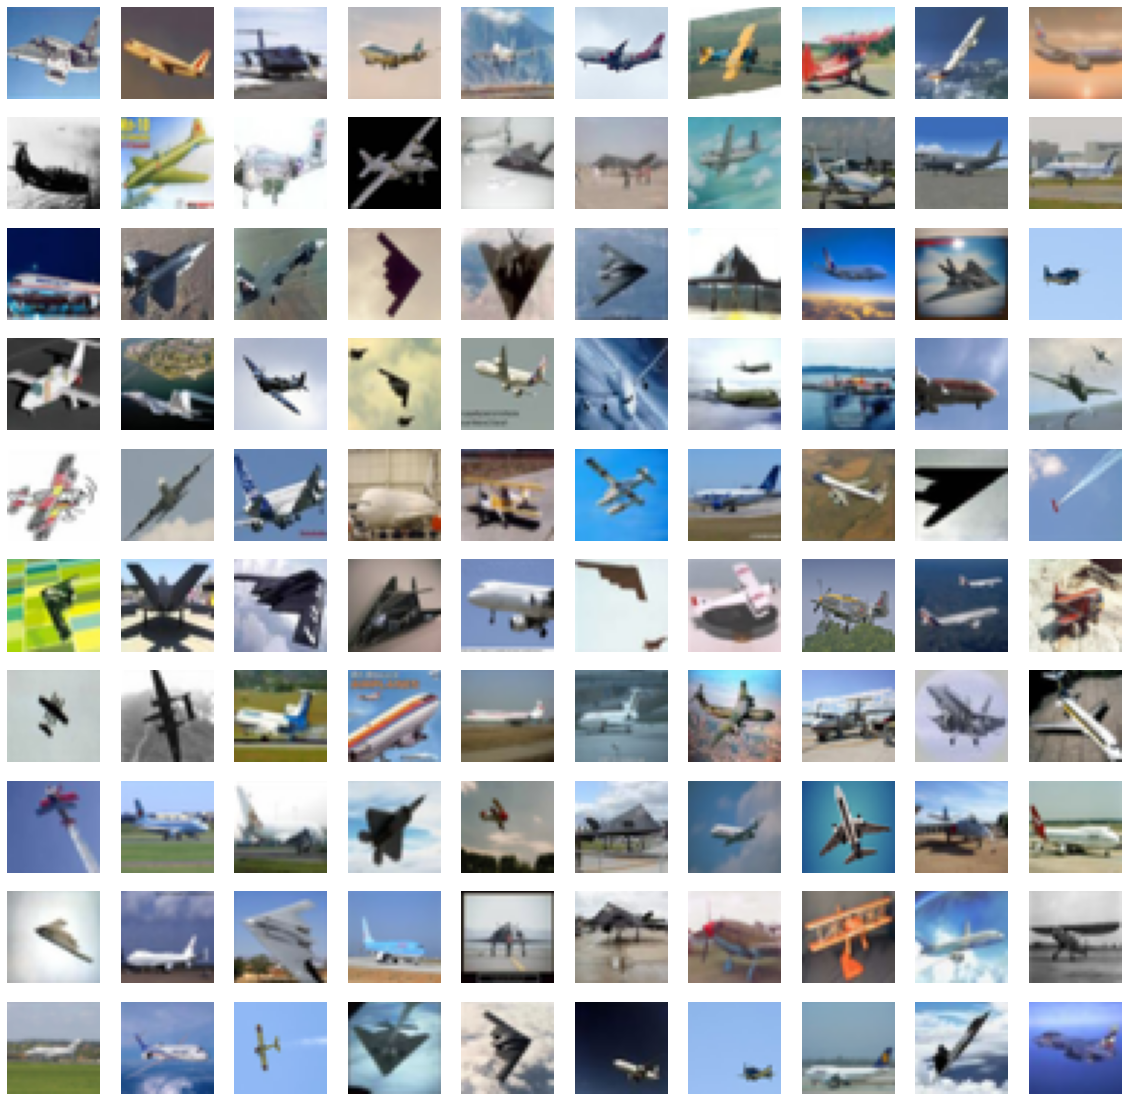

In [ ]:
plt.figure(figsize=(20,20))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(validation_data[i])

print(validation_labels[0:100])